In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from yahoofinancials import YahooFinancials
from finta import TA
import gym_anytrading
from gym_anytrading.envs import StocksEnv

from datetime import date
from datetime import timedelta

from keras.models import Sequential
from keras.layers import LSTM, Dense
import random

In [42]:
symbol = 'TSLA'

years = 2

years = 365*years

endDate = date.today()

startDate = endDate - timedelta(years)

stock = YahooFinancials(symbol)

stock_price_data = pd.DataFrame(stock.get_historical_price_data(str(startDate), str(endDate), 'daily')[symbol]['prices'])

stock_price_data.head()


,date,high,low,open,close,volume,adjclose,formatted_date
0,1557754200,15.498000,14.966667,15.467333,15.134000,162522000,15.134000,2019-05-13
1,1557840600,15.633333,15.200000,15.286667,15.487333,108786000,15.487333,2019-05-14
2,1557927000,15.496000,15.016667,15.288000,15.463333,109440000,15.463333,2019-05-15
3,1558013400,15.400000,15.100000,15.299333,15.222000,112249500,15.222000,2019-05-16
4,1558099800,14.816000,13.928000,14.797333,14.068667,266800500,14.068667,2019-05-17


In [43]:
stock_price_data.drop(columns=['date'], inplace=True)

In [44]:
stock_price_data.dropna(inplace=True)

In [45]:
stock_price_data.rename(columns={'formatted_date':'date'}, inplace=True)
stock_price_data['date'] = pd.to_datetime(stock_price_data['date'])
stock_price_data.set_index('date', inplace=True)

In [46]:
stock_price_data.columns = [x.capitalize() for x in stock_price_data.columns]

In [47]:
stock_ind_data = stock_price_data.copy()

In [48]:
stock_ind_data

,High,Low,Open,Close,Volume,Adjclose
date,,,,,,
2019-05-13,15.498000,14.966667,15.467333,15.134000,162522000,15.134000
2019-05-14,15.633333,15.200000,15.286667,15.487333,108786000,15.487333
2019-05-15,15.496000,15.016667,15.288000,15.463333,109440000,15.463333
2019-05-16,15.400000,15.100000,15.299333,15.222000,112249500,15.222000
2019-05-17,14.816000,13.928000,14.797333,14.068667,266800500,14.068667
...,...,...,...,...,...,...
2023-05-04,162.949997,159.649994,162.710007,161.199997,95108500,161.199997
2023-05-05,170.789993,163.509995,163.970001,170.059998,107440900,170.059998
2023-05-08,173.800003,169.190002,173.720001,171.789993,112249400,171.789993


# Adding Indicators

In [49]:
stock_ind_data['RSI'] = TA.RSI(stock_ind_data)
stock_ind_data['MACD'] = TA.MACD(stock_ind_data)['MACD']
stock_ind_data['MACD_SIGNAL'] = TA.MACD(stock_ind_data)['SIGNAL']
stock_ind_data['OBV'] = TA.OBV(stock_ind_data)
stock_ind_data['STOCH'] = TA.STOCH(stock_price_data)
stock_ind_data['STOCHD'] = TA.STOCHD(stock_price_data)
stock_ind_data.dropna(inplace=True)
stock_ind_data.head()

,High,Low,Open,Close,Volume,Adjclose,RSI,MACD,MACD_SIGNAL,OBV,STOCH,STOCHD
date,,,,,,,,,,,,
2019-06-04,12.932000,11.974000,12.073333,12.906667,207112500,12.906667,36.483934,-0.301794,-0.264846,-1.290792e+09,29.954928,11.833666
2019-06-05,13.418667,12.790000,13.245333,13.106000,202662000,13.106000,40.180045,-0.256501,-0.263139,-1.088130e+09,36.289591,23.229132
2019-06-06,14.066667,13.453333,13.629333,13.730000,303633000,13.730000,49.990769,-0.179322,-0.246068,-7.844970e+08,63.999994,43.414838
2019-06-07,14.056000,13.566667,13.666667,13.633333,240052500,13.633333,48.659403,-0.124030,-0.221304,-1.024550e+09,80.887977,60.392520
2019-06-10,14.462667,13.934000,14.016667,14.192000,158775000,14.192000,55.959410,-0.043500,-0.185328,-8.657745e+08,89.837287,78.241753


# Custom Environment with indicators

In [50]:
def process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['RSI', 'MACD', 'MACD_SIGNAL', 'OBV', 'STOCH','STOCHD']]
    return prices, signal_features

class MyStocksEnv(StocksEnv):
    _process_data = process_data

In [51]:
env = MyStocksEnv(df=stock_ind_data, frame_bound=(10, stock_ind_data.shape[0]-365), window_size=10)

In [52]:
for i in range(100):
    done = False
    r = 0
    state = env.reset()
    while not done:
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        r+=reward
        if done: 
            print('Episode: {}, info: {}'.format(i, info))
            break

        

Episode: 0, info: {'total_reward': 175.22608184814453, 'total_profit': 0.2845113486498061, 'position': 1}
Episode: 1, info: {'total_reward': 230.8105812072754, 'total_profit': 1.4315063432161779, 'position': 1}
Episode: 2, info: {'total_reward': 16.480090141296387, 'total_profit': 0.18997487915035266, 'position': 0}
Episode: 3, info: {'total_reward': 228.89001083374023, 'total_profit': 0.6327019886025878, 'position': 1}
Episode: 4, info: {'total_reward': 204.9940309524536, 'total_profit': 0.3236169216025814, 'position': 0}
Episode: 5, info: {'total_reward': 195.9633083343506, 'total_profit': 1.0569818180746278, 'position': 1}
Episode: 6, info: {'total_reward': 265.5753335952759, 'total_profit': 0.5505197766278944, 'position': 0}
Episode: 7, info: {'total_reward': 136.68321704864502, 'total_profit': 0.24192562359620193, 'position': 1}
Episode: 8, info: {'total_reward': 191.52266120910645, 'total_profit': 0.6406251751708927, 'position': 1}
Episode: 9, info: {'total_reward': 193.732095718

In [53]:
class SumTree(object):
    data_pointer = 0
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2*capacity-1)
        self.data = np.zeros(capacity, dtype=object)
        self.length = 0
        
    def update(self, tree_index, priority):
        change = priority-self.tree[tree_index]
        self.tree[tree_index] = priority
        
        while tree_index>0:
            tree_index = (tree_index-1)//2
            self.tree[(tree_index)] += change
    
    def add(self, priority, data):
        tree_index = self.data_pointer+self.capacity-1
        self.data[self.data_pointer] = data
        self.update(tree_index, priority)
        self.data_pointer+=1
        if(self.data_pointer>=self.capacity):
            self.data_pointer=0
        else: 
            self.length+=1
    
    def get_leaf(self, v):
        pi = 0
        while True:
            lci = pi*2+1
            rci = lci+1
            
            if lci>=self.capacity:
                leaf_index = pi
                break
            else:
                if v<=self.tree[lci]:
                    pi = lci
                else:
                    v-=self.tree[lci]
                    pi = rci
        data_index = leaf_index-self.capacity+1
        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        return self.tree[0]

In [54]:
class Memory(object):
    e = 0.04
    a = 0.6
    b = 0.4
    b_increment = 0.001
    absolute_error_upper = 1   
    
    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.capacity=capacity
        self.memories_n = 0
    
    def store(self, experience):
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        if max_priority == 0:
            max_priority = self.absolute_error_upper
        self.tree.add(max_priority, experience)
        self.memories_n+=1
    
    def sample(self, n):
        minibatch = []
        b_idx = np.empty((n,), dtype=np.int32)
        priority_segment = self.tree.total_priority/n
        for i in range(n):
            A,B = priority_segment*i, priority_segment*(i+1)
            value = np.random.uniform(A,B)
            index, priority, data = self.tree.get_leaf(value)
            b_idx[i] = index
            minibatch.append(list(data))
        return b_idx, minibatch
    
    def batch_update(self, tree_idx, abs_error):
        abs_error+=self.e
        clipped_error = np.minimum(abs_error, self.absolute_error_upper)
        ps = np.power(clipped_error, self.a)
        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

In [55]:
class Actor:

    def __init__(self,  env, batch_size, learner):
        self.env = env
        self.state = np.array(self.env.reset())
        self.learner = learner
        self.model = self.build_model()
        self.discount_factor = 0.92
        self.local_memory = []
        self.replay_memory = learner.replay_memory
        self.batch_size = batch_size
        


    def build_model(self):
        model = Sequential()
        model.add(LSTM(300, input_shape=(self.state.shape[0], self.state.shape[1]), return_sequences=True, activation='relu'))
        model.add(LSTM(200, activation='relu'))
        model.add(Dense(self.learner.action_shape, activation='softmax'))
        
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        return model
    
    def update_weights(self):
        self.model.set_weights(self.learner.model.get_weights())
    
    def get_action(self, state):
        state = np.array(state).reshape(self.learner.state_shape)
        # print(state.shape)
        action = np.argmax(self.model.predict(state)[0])
        return action
    
    def compute_TD(self, minibatch):
        curr_state = []
        next_state = []
        actions = []
        rewards = []
        done = []
        qValues = []

        for i in range(self.batch_size):
            curr_state.append(minibatch[i][0].reshape(self.learner.state_shape))
            actions.append(minibatch[i][1])
            rewards.append(minibatch[i][2])
            next_state.append(minibatch[i][3].reshape(self.learner.state_shape))
            done.append(minibatch[i][4])
            qValues.append(self.model.predict(curr_state[i])[0])
            qValue_ns = np.amax(self.model.predict(next_state[i])[0])
            if done[i]:
                qValues[i][actions[i]] = rewards[i]
            else:
                qValues[i][actions[i]] = rewards[i] + self.discount_factor*qValue_ns
        
        qValues = np.array(qValues)
        curr_state = np.array(curr_state)
        actions = np.array(actions)

        pred_qValues = np.array([self.model.predict(x)[0] for x in curr_state])
        indices = np.arange(self.batch_size)
        abs_error = np.abs(qValues[indices, actions]-pred_qValues[indices, actions])

        return abs_error
        

    def perform_action(self):
        action = self.get_action(self.state)
        next_state, reward, done, info = self.env.step(action)
        next_state = np.array(next_state)
        self.local_memory.append([self.state, action, reward, next_state, done])
        if len(self.local_memory) >= self.batch_size:
            minibatch = self.local_memory[-self.batch_size:]
            TD = self.compute_TD(minibatch)
            TD += self.replay_memory.e
            clipped_error = np.minimum(TD, self.replay_memory.absolute_error_upper)
            priority = np.power(clipped_error, self.replay_memory.a)
            for data, p in zip(minibatch, clipped_error):
                self.replay_memory.tree.add(p, data)
                self.replay_memory.memories_n+=1
        self.state = next_state


        

In [62]:

class Learner:
    
    def __init__(self, state_shape, action_shape, memory_size, batch_size=24, ddqn_flag=False):
        self.ddqn = ddqn_flag
        self.action_shape = action_shape
        #hyper parameters
        self.discount_factor = 0.9
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.04
        self.batch_size = batch_size
        self.train_start = 10000
        self.dueling_option = 'avg'
        self.memory_size = memory_size
        self.memories_n = 0

        self.state_shape = (1, state_shape[0], state_shape[1])
        
        #memory
        self.replay_memory = Memory(self.memory_size)
        
        #model
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.target_model.set_weights(self.model.get_weights())     
    
    def build_model(self):
        
        model = Sequential()
        model.add(LSTM(300, input_shape=(self.state_shape[1], self.state_shape[2]), return_sequences=True, activation='relu'))
        model.add(LSTM(200, activation='relu'))
        model.add(Dense(self.action_shape, activation='softmax'))
        
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        return model
        
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_shape)
        else:
            return np.argmax(self.model.predict(state.reshape(self.state_shape))[0])
    
    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            print('hi#####helloooooooooooooooo')
            
    def get_target_q_value(self, next_state):
        
        if self.ddqn:
            action = np.argmax(self.model.predict(next_state)[0])
            max_q_value = self.target_model.predict(next_state)[0][action]
            
        else:
            max_q_value = np.amax(self.target_model.predict(next_state)[0])
        return max_q_value
    
    def update_target_model(self, tau=0.003):
        if self.ddqn:
            weights = self.model.get_weights()
            target_weights = self.target_model.get_weights()
            
            for i in range(len(target_weights)):
                target_weights[i] = weights[i]*tau + target_weights[i]*(1-tau)
            self.target_model.set_weights(target_weights)
        else:
            self.target_model.set_weights(self.model.get_weights())
    
    def experience_replay(self):
        if self.replay_memory.memories_n < self.replay_memory.capacity:
            return
        
        tree_idx, minibatch = self.replay_memory.sample(self.batch_size)
        current_state = np.zeros((self.batch_size, self.state_shape[1], self.state_shape[2]))
        next_state = np.zeros((self.batch_size, self.state_shape[1], self.state_shape[2]))
        actions = np.zeros(self.batch_size, dtype=int)
        rewards = np.zeros(self.batch_size)
        done = np.zeros(self.batch_size, dtype=bool)
        qValues = np.zeros((self.batch_size, self.action_shape))
        for i in range(self.batch_size):
            current_state[i] = minibatch[i][0].reshape((self.state_shape[1], self.state_shape[2]))
            next_state[i] = minibatch[i][3].reshape((self.state_shape[1], self.state_shape[2]))
            actions[i] = minibatch[i][1]
            rewards[i] = minibatch[i][2]
            done[i] = minibatch[i][4]

            qValues[i] = self.model.predict(current_state[i].reshape(self.state_shape))
            qValue_ns = self.get_target_q_value(next_state[i].reshape(self.state_shape))

            if done[i]:
                qValues[i][actions[i]] = rewards[i]
            else:
                qValues[i][actions[i]] = rewards[i] + self.discount_factor*qValue_ns
        
        #calculating TD
        pred_qValues = np.array(self.model.predict(current_state))
        indices = np.arange(self.batch_size)
        absolute_errors = np.abs(qValues[indices, actions]-pred_qValues[indices, actions])
        self.replay_memory.batch_update(tree_idx, absolute_errors)

        #train
        self.model.fit(current_state, qValues, batch_size=self.batch_size, epochs=1, verbose=0)
        self.update_epsilon()
        
                    
        

In [57]:
timesteps = 10
test_n = 365
env = MyStocksEnv(df=stock_ind_data, frame_bound=(timesteps, stock_ind_data.shape[0]-test_n), window_size=timesteps)


In [58]:
def build_actors(df, batch_size, learner, test_n, n):
    actors = []
    for i in range(n):
        env = MyStocksEnv(df=stock_ind_data, frame_bound=(batch_size, stock_ind_data.shape[0]-test_n), window_size=batch_size)
        actors.append(Actor(env, batch_size=batch_size, learner=learner))
    return actors

In [63]:
episodes = 1
state = np.array(env.reset())
learner = Learner(state_shape = state.shape, action_shape = env.action_space.n, memory_size=100, ddqn_flag=True)
actors_n = 4
actors = build_actors(df=stock_ind_data, batch_size=timesteps, learner=learner, n=actors_n, test_n=test_n)

for e in range(episodes):
    done = False
    r = 0
    state = np.array(env.reset())
    while not done:
        for actor in actors:
            actor.perform_action()
        action = learner.get_action(state)
        next_state, reward, done, info = env.step(action)
        next_state = np.array(next_state)
        learner.experience_replay()
        for actor in actors:
            actor.update_weights()
        if done:
            print("Episode: {}, Info: ()".format(e, info))
            break
        state = next_state
        
            


1/1 [==============================] - 0s 26ms/step
hi#####helloooooooooooooooo
1/1 [==============================] - 0s 25ms/step
hi#####helloooooooooooooooo
1/1 [==============================] - 0s 27ms/step
hi#####helloooooooooooooooo
1/1 [==============================] - 0s 50ms/step
hi#####helloooooooooooooooo
1/1 [==============================] - 0s 26ms/step
hi#####helloooooooooooooooo
1/1 [==============================] - 0s 26ms/step
hi#####helloooooooooooooooo
1/1 [==============================] - 0s 25ms/step
hi#####helloooooooooooooooo
1/1 [==============================] - 0s 27ms/step
hi#####helloooooooooooooooo
1/1 [==============================] - 0s 26ms/step
hi#####helloooooooooooooooo
1/1 [==============================] - 0s 28ms/step
hi#####helloooooooooooooooo
1/1 [==============================] - 0s 27ms/step
hi#####helloooooooooooooooo
1/1 [==============================] - 0s 29ms/step
hi#####helloooooooooooooooo
1/1 [==============================] - 0

KeyboardInterrupt: 

env.render_all()
plt.show()

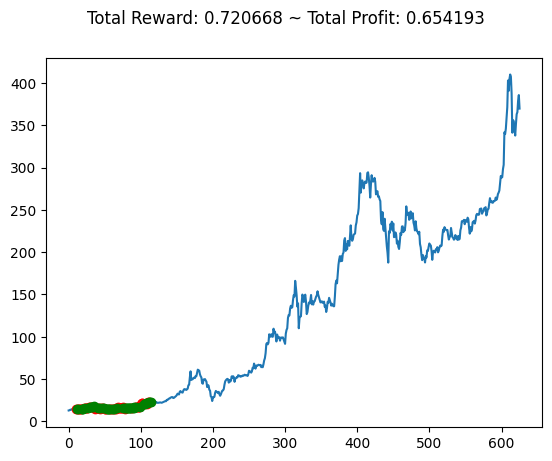

In [64]:
env.render_all()
plt.show()